In [ ]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis

import random



1.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:


import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [ ]:
from random import sample

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.linalg import inv

In [ ]:

import os
# os.getcwd()

In [ ]:
dataset = os.path.join(os.getcwd(),'Cora')
dataset

'/content/Cora'

In [ ]:
from torch_geometric.datasets import Planetoid

In [ ]:
from torch_geometric.datasets import WebKB
from torch_geometric.utils import to_dense_adj

dataset = Planetoid(root='/citeseer',name='Citeseer')
print(dataset[0])
adj = to_dense_adj(dataset[0].edge_index)
adj = adj[0]
labels = dataset[0].y
labels = labels.numpy()

X = dataset[0].x
X = X.to_dense()
N = X.shape[0]
NO_OF_CLASSES =  len(set(np.array(dataset[0].y)))

print(X.shape, adj.shape)

nn = int(1*N)
X = X[:nn,:]
adj = adj[:nn,:nn]
labels = labels[:nn]
print(X.shape,adj.shape)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
torch.Size([3327, 3703]) torch.Size([3327, 3327])
torch.Size([3327, 3703]) torch.Size([3327, 3327])


In [ ]:
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [ ]:
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [ ]:
from torch_geometric.datasets import WebKB
from torch_geometric.utils import to_dense_adj

dataset = WebKB(root='/texas',name='Texas')
print(dataset[0])
adj = to_dense_adj(dataset[0].edge_index)
adj = adj[0]
labels = dataset[0].y
labels = labels.numpy()

X = dataset[0].x
X = X.to_dense()
N = X.shape[0]
NO_OF_CLASSES =  len(set(np.array(dataset[0].y)))

print(X.shape, adj.shape)

nn = int(1*N)
X = X[:nn,:]
adj = adj[:nn,:nn]
labels = labels[:nn]
print(X.shape,adj.shape)

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])
torch.Size([183, 1703]) torch.Size([183, 183])
torch.Size([183, 1703]) torch.Size([183, 183])


Processing...
Done!


In [ ]:
dataset

Citeseer()

In [ ]:
del dataset

In [ ]:
def get_laplacian(adj):
    b=torch.ones(adj.shape[0])
    return torch.diag(adj@b)-adj

theta = get_laplacian(adj)
print(theta.shape)


torch.Size([3327, 3327])


In [ ]:
# dataset_name = 'flickr' 

# data = Dataset(root='', name=dataset_name, setting='gcn',seed=10)

# adj, features, labels = data.adj, data.features, data.labels
# idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

# theta = csgraph.laplacian(adj).tocsr()
features = X.numpy()
NO_OF_NODES = X.shape[0]
# NO_OF_CLASSES =  7


print(NO_OF_CLASSES,NO_OF_NODES)

6 3327


In [ ]:
def convertScipyToTensor(coo):
  try:
    coo = coo.tocoo()
  except:
    coo = coo
  values = coo.data
  indices = np.vstack((coo.row, coo.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = coo.shape

  return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [ ]:

from scipy.sparse import random
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix

p = X.shape[0]
k = int(p*0.1)
n = X.shape[1]
lambda_param = 100
beta_param = 50
alpha_param = 100
gamma_param = 100
lr = 1e-5
thresh = 1e-10

from scipy.sparse import random
from scipy.stats import rv_continuous
class CustomDistribution(rv_continuous):
    def _rvs(self,  size=None, random_state=None):
        return random_state.standard_normal(size)
temp = CustomDistribution(seed=1)
temp2 = temp()  # get a frozen version of the distribution
X_tilde = random(k, n, density=0.25, random_state=1, data_rvs=temp2.rvs)
C = random(p, k, density=0.25, random_state=1, data_rvs=temp2.rvs)



In [ ]:
def experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.1)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*(CX_tilde-X)@(X_tildeT)
          t3 = 2*thetacX_tilde@(X_tildeT)
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(thetaC@CT@thetaC)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = t1
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(50)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(X.shape[1], 64)
        self.conv2 = GCNConv(64, NO_OF_CLASSES)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):

        #print("Checking 1: x", x.shape, "Edge index:", edge_index.shape)
        x = self.conv1(x, edge_index)
        #print("Checking 2: convolution done, new x:", x.shape)
        x = F.relu(x)
        #print("Checking 3: x", x.shape, "training:", self.training)
        x = F.dropout(x, training=self.training)
        #print("Checking 4: dropout done new x", x.shape, "Edge index:", edge_index.shape)
        x = self.conv2(x, edge_index)
        #print("Checking 5: x", x.shape)

        return F.log_softmax(x, dim=1)



In [ ]:
from random import sample

In [ ]:
def get_accuracy(C_0,L,X_t_0):
    global labels, NO_OF_CLASSES,k
    t=[]
    for i in [1,2,3,4,5,6,7,8,9,10]: 
        C_0_new=np.zeros(C_0.shape)
        for i in range(C_0.shape[0]):
            C_0_new[i][np.argmax(C_0[i])]=1
        # print(C_0_new)
        # C_0_new=C_0
        from scipy import sparse
        #Lc=C_0.T@L@C_0
        Lc=C_0_new.T@L@C_0_new
        # print("L:", Lc.shape)
        # Lc=L_new
        #print(Lc)
        Wc=(-1*Lc)*(1-np.eye(Lc.shape[0]))
        # print("W:", Wc.shape)
        Wc[Wc<0.1]=0
        Wc=sparse.csr_matrix(Wc)
        Wc = Wc.tocoo()
        row = torch.from_numpy(Wc.row).to(torch.long)
        col = torch.from_numpy(Wc.col).to(torch.long)
        edge_index_coarsen2 = torch.stack([row, col], dim=0)
        #print("edgecoarsen:", edge_index_coarsen2.shape)
        edge_weight = torch.from_numpy(Wc.data)
        #print("edgeweight:", edge_weight.shape)
        def one_hot(x, class_count):
            return torch.eye(class_count)[x, :]

        device = torch.device('cpu')
        labels=labels
        Y = labels
        #print("Y:", Y.shape)
        Y = one_hot(Y,NO_OF_CLASSES)
        # NO_OF_CLASSES=Y.shape[1]
        P=np.linalg.pinv(C_0_new)
        labels_coarse = torch.argmax(torch.sparse.mm(torch.Tensor(P).double() , Y.double()).double() , 1)
        labels_c=labels_coarse
        #print("Lables:", labels_coarse.shape)

        #torch.Tensor(C2)@X
        Wc=Wc.toarray()
        #Wc[Wc<0.01]=0
        C2=np.linalg.pinv(C_0_new)
        model=Net().to(device)
        device = torch.device('cpu')
        lr=0.01
        decay=0.0001
        # try:
        #   X=np.array(features.todense())
        # except:
        #   X = np.array(features)
        #print("X:",X.shape)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
        # criterion=torch.nn.CrossEntropyLoss()
        x=sample(range(0, int(k)), k)
      
        from datetime import datetime
        Xt=P@X
        # Xt=X_t_0
        def train():
            model.train()
            optimizer.zero_grad()
            out = model(torch.Tensor(Xt).to(device),edge_index_coarsen2)
            loss = F.nll_loss(out[x], labels_coarse[x])
            loss.backward()
            optimizer.step()
            return loss
        now1 = datetime.now()
        losses=[]
        for epoch in range(60):
            loss=train()
            losses.append(loss)
            if(epoch%100==0):
                print(f'Epoch: {epoch:03d},loss: {loss:.4f}')
        now2 = datetime.now()        
        pred=model(torch.Tensor(Xt).to(device),edge_index_coarsen2).argmax(dim=1)        
        def train_accuracy():
            model.eval()
            correct = (pred[x] == labels_coarse[x]).sum()
            acc = int(correct) /len(x)
            return acc
    
        t+=[(now2-now1).total_seconds()]

        zz=sample(range(0, int(NO_OF_NODES)), NO_OF_NODES)
        Wc=sparse.csr_matrix(adj)
        Wc = Wc.tocoo()
        row = torch.from_numpy(Wc.row).to(torch.long)
        col = torch.from_numpy(Wc.col).to(torch.long)
        edge_index_coarsen = torch.stack([row, col], dim=0)
        edge_weight = torch.from_numpy(Wc.data)
        pred=model(torch.Tensor(X),edge_index_coarsen).argmax(dim=1)
        pred=np.array(pred)
        correct =(pred[zz]==labels[zz]).sum()
        acc = int(correct) /NO_OF_NODES
        return acc



In [ ]:
# 0.0001 1e-05 100 0.01
for lambda_param in [0.001]:
  for beta_param in [0.01]:
    for alpha_param in [1]:
      for gamma_param in [0.001]:
        av = []

        for _ in range(1):
          X_tilde = random(k, n, density=0.15, random_state=1, data_rvs=temp2.rvs)
          C = random(p, k, density=0.15, random_state=1, data_rvs=temp2.rvs)
          X_t_0,C_0 = experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,torch.tensor(X))
          L = theta
          C_0 = C_0.cpu().detach().numpy()
          X_t_0 = X_t_0.cpu().detach().numpy()
          # X = X.cpu().detach().numpy()
          C_t_0 = C_0.T
          # L = theta.to_dense()
          try:
            L = L.cpu().detach().numpy()
          except:
            L = L
          
          acc = get_accuracy(C_0,L,X_t_0)
          av.append(acc)
          print("Accuracy = " + str(acc) + " " + str(lambda_param)+" " + str(beta_param)+" "+str(alpha_param)+" "+str(gamma_param))
        print("Average accuracy = " + str(np.mean(av)*100)  + " +/- " + str(np.std(av)*100)) 


In [ ]:








































...

In [ ]:
from scipy import sparse 

In [ ]:
C_0_new=np.zeros(C_0.shape)
for i in range(C_0.shape[0]):
    C_0_new[i][np.argmax(C_0[i])]=1

# Wc=sparse.csr_matrix(Wc)
# Wc = Wc.tocoo()
# row = torch.from_numpy(Wc.row).to(torch.long)
# col = torch.from_numpy(Wc.col).to(torch.long)
# edge_index_coarsen2 = torch.stack([row, col], dim=0)
# edge_weight = torch.from_numpy(Wc.data)
def one_hot(x, class_count):
    return torch.eye(class_count)[x, :]
device = torch.device('cpu')
labels=labels
Y = labels

Y = one_hot(Y,NO_OF_CLASSES)

P=np.linalg.pinv(C_0_new)
labels_coarse = torch.argmax(torch.sparse.mm(torch.Tensor(P).double() , Y.double()).double() , 1)
print((labels_coarse==0).sum())
print((labels_coarse==1).sum())
print((labels_coarse==2).sum())
print((labels_coarse==3).sum())
print((labels_coarse==4).sum())
print((labels_coarse==5).sum())
print((labels_coarse==6).sum())

tensor(28)
tensor(11)
tensor(16)
tensor(44)
tensor(19)
tensor(7)
tensor(10)


In [ ]:
len(labels_coarse)

135

In [ ]:
Lc=C_0.T@L@C_0
Wc=(-1*Lc)*(1-np.eye(Lc.shape[0]))
Wc[Wc<0.1]=0
print((Wc!=0).sum()/(2*Wc.shape[0]))

3.1481481481481484


In [ ]:
Wc.shape

(135, 135)

In [ ]:
# !pip install networkx==2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556009 sha256=3961a42ee80aa01d69fa95863e55cf12550359c02d69b44ae28ad83f6a4c300c
  Stored in directory: /root/.cache/pip/wheels/ff/62/9e/0ed2d25fd4f5761e2d19568cda0c32716556dfa682e65ecf64
Successfully built networkx
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [ ]:
c=["#FFFF00","#00FF00","#FF0000","#0000FF","#ADD8E6","#FF00FF","#7FFFD4"]
C=[]

In [ ]:
for i in range(len(labels_coarse)):
  if(labels_coarse[i]==0):
    C+=["#FFFF00"];
  elif(labels_coarse[i]==1):
    C+=["#00FF00"]; 
  elif(labels_coarse[i]==2):
    C+=[c[2]];  
  elif(labels_coarse[i]==3):
    C+=[c[3]];  
  elif(labels_coarse[i]==4):
    C+=[c[4]];  
  elif(labels_coarse[i]==5):
    C+=[c[5]];  
  elif(labels_coarse[i]==6):
    C+=[c[6]];                  



In [ ]:
C=np.array(C)
C.shape

(135,)

[autoreload of networkx.utils.decorators failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.8/dist-packages/networkx/utils/decorators.py", line 15, in <module>
    from networkx.utils import is_string_like, create_random_state, \
ImportError: cannot import name 'is_string_like' from 'n

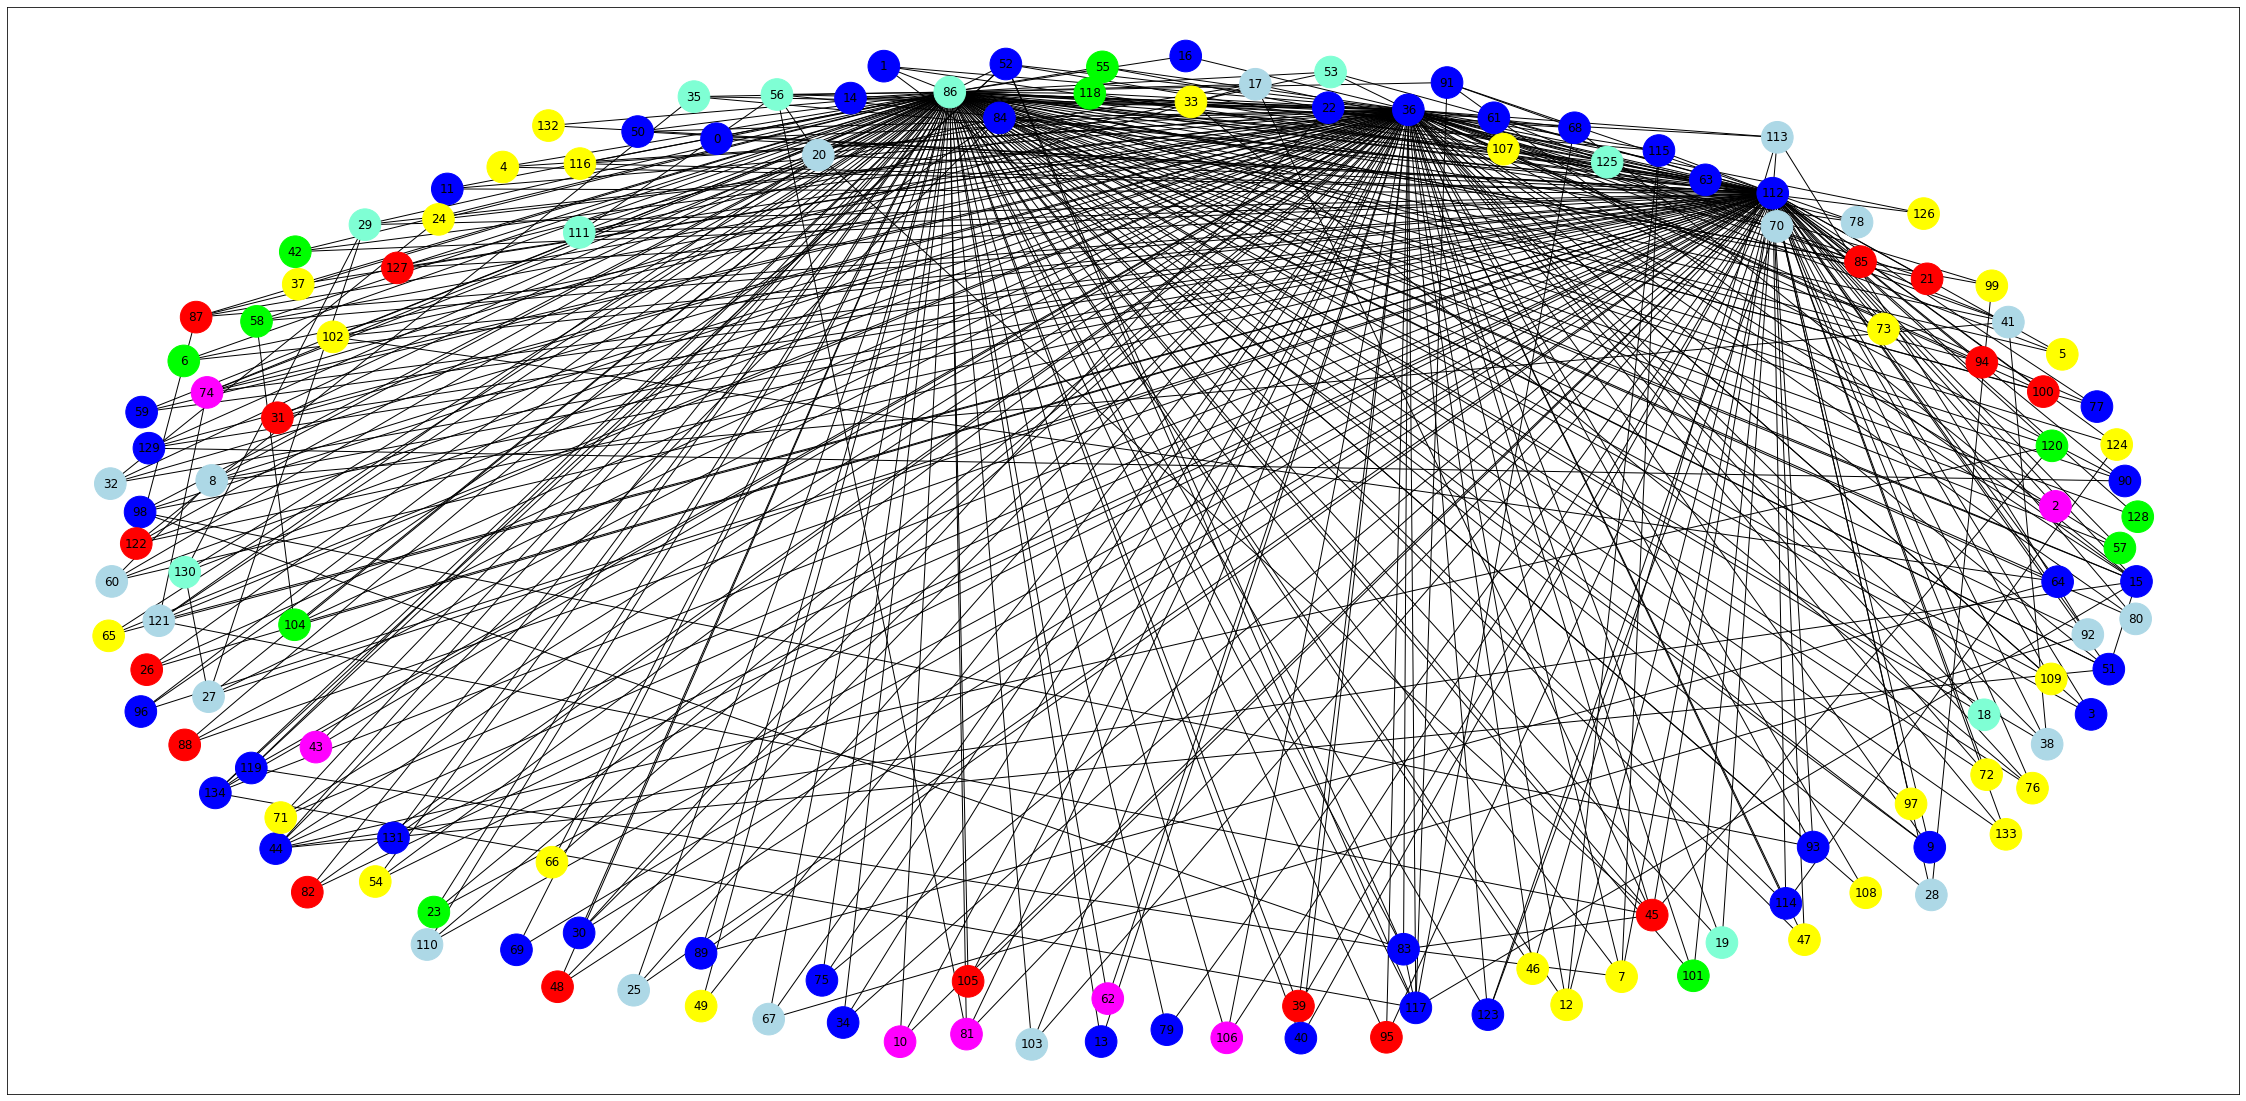

In [ ]:
import networkx as nx
fig = plt.figure(1, figsize=(40, 20))
nx.draw_networkx(nx.from_numpy_matrix(Wc),node_color=C,pos=nx.spring_layout(nx.from_numpy_matrix(Wc)),node_size=1000)

In [ ]:
model = torch.load("adj_cora_0.5_1.pt")
model

tensor([[0.0000, 0.8537, 0.8590,  ..., 0.0307, 0.0597, 0.0324],
        [0.8537, 0.0000, 0.8583,  ..., 0.0361, 0.0667, 0.0386],
        [0.8590, 0.8583, 0.0000,  ..., 0.0298, 0.0539, 0.0326],
        ...,
        [0.0307, 0.0361, 0.0298,  ..., 0.0000, 0.6507, 0.6414],
        [0.0597, 0.0667, 0.0539,  ..., 0.6507, 0.0000, 0.6126],
        [0.0324, 0.0386, 0.0326,  ..., 0.6414, 0.6126, 0.0000]],
       device='cuda:0')

/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


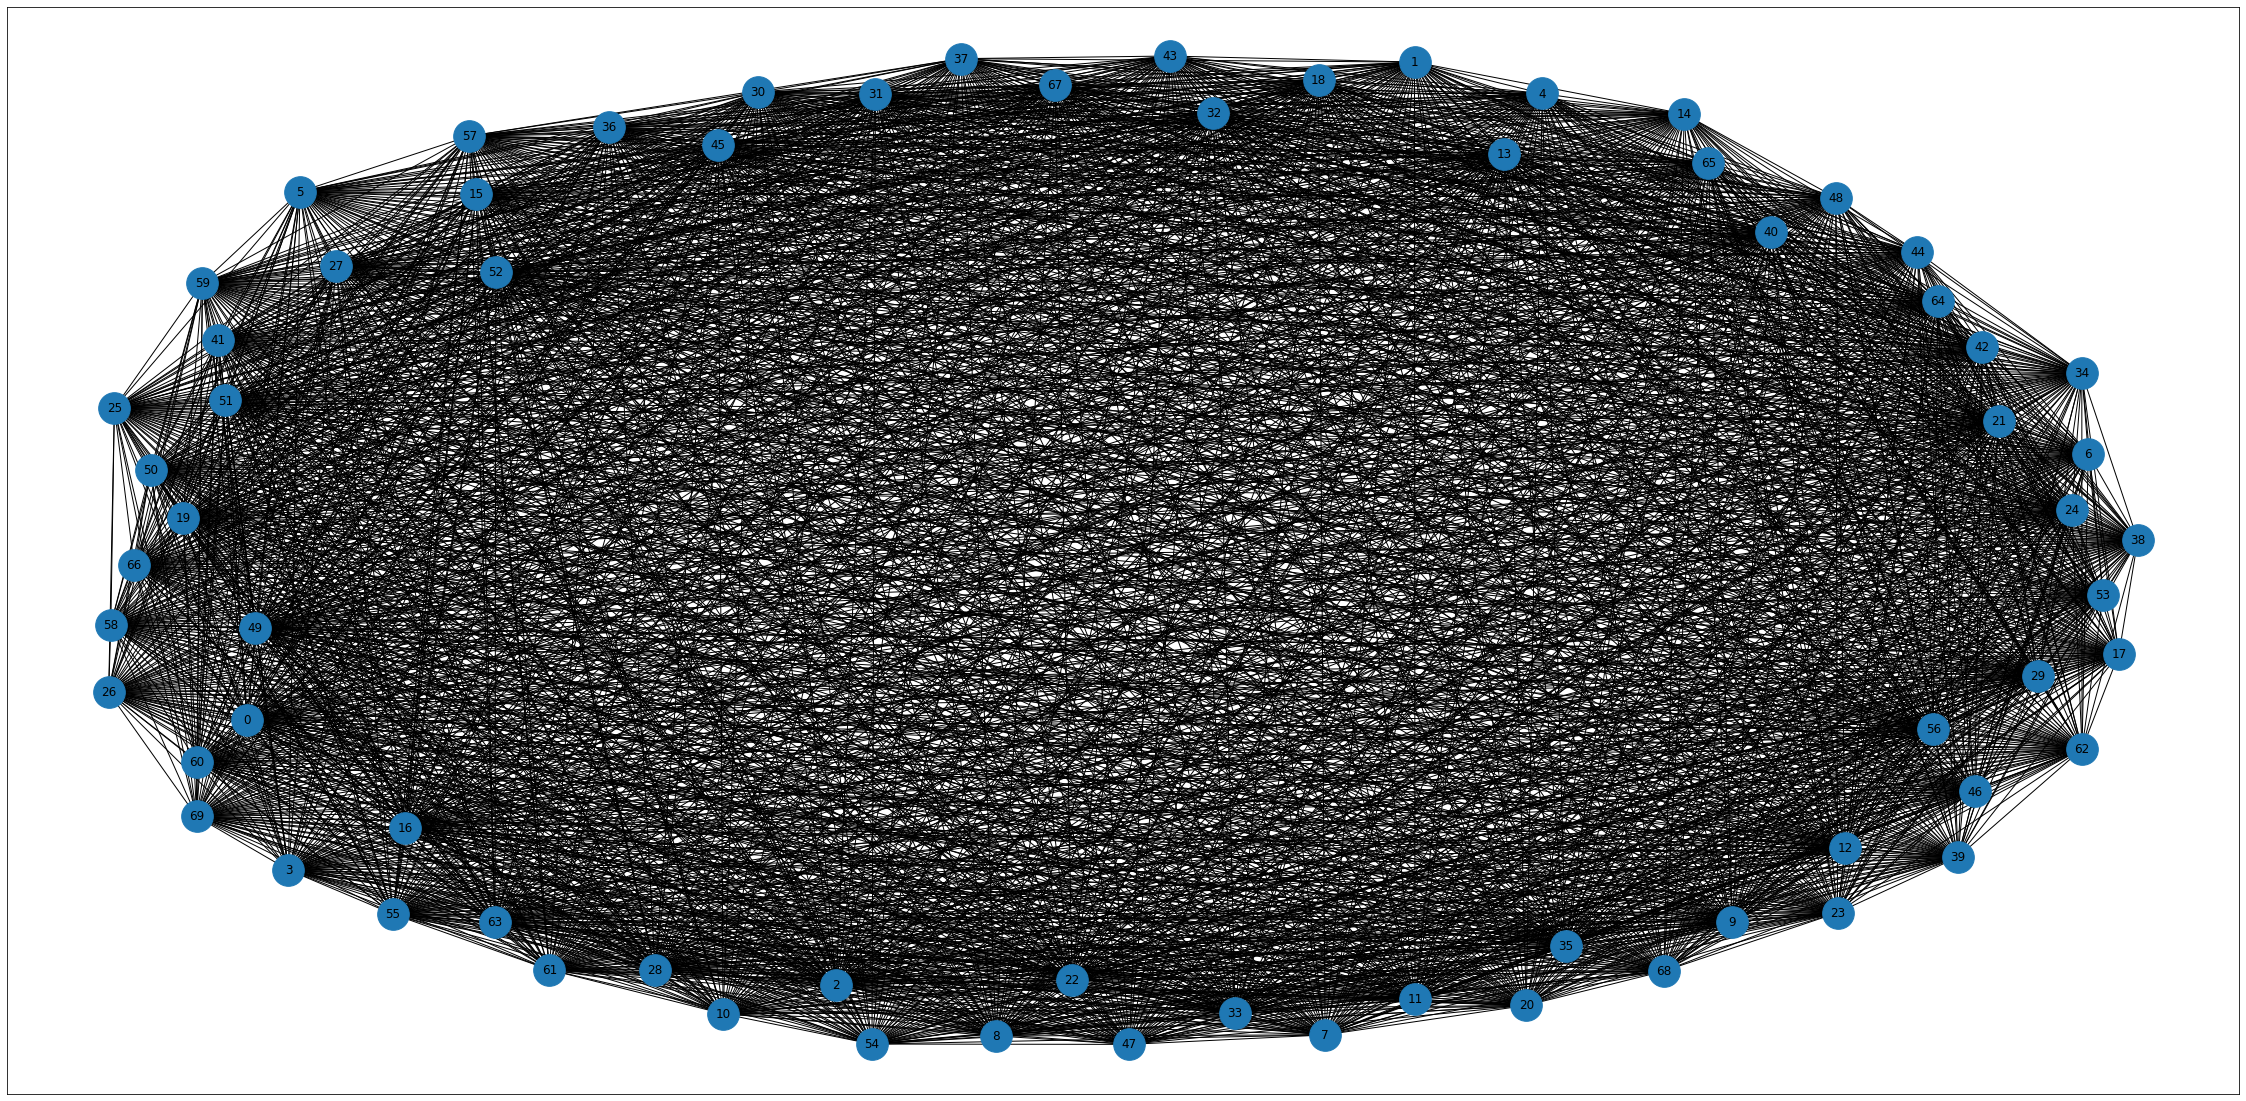

In [ ]:
import networkx as nx
fig = plt.figure(1, figsize=(40, 20))
Wcc=model.detach().cpu().numpy()
nx.draw_networkx(nx.from_numpy_matrix(Wcc),pos=nx.spring_layout(nx.from_numpy_matrix(Wcc)),node_size=1000)

In [ ]:
model.shape

torch.Size([70, 70])

In [ ]:
# model.tonumpy()

In [ ]:
import networkx as nx
fig = plt.figure(1, figsize=(100, 50))
nx.draw_networkx(nx.from_numpy_matrix(Wc),node_color="#FFFF00",pos=nx.spring_layout(nx.from_numpy_matrix(Wc)),node_size=600)

In [ ]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
Lc=C_0.T@L@C_0
Lc

array([[ 2.93628101e+01, -1.27927229e-01, -3.34231108e-02, ...,
        -5.99807799e-01, -8.21857154e-02, -1.70668334e-01],
       [-1.27927229e-01,  5.17648697e+01, -4.84500453e-02, ...,
        -5.97011335e-02, -9.85938311e-02, -1.85695261e-01],
       [-3.34230922e-02, -4.84500453e-02,  9.55235767e+00, ...,
         3.48029993e-02, -2.70850398e-03, -9.11911130e-02],
       ...,
       [-5.99807680e-01, -5.97011112e-02,  3.48030068e-02, ...,
         2.47972813e+01, -1.39596164e-02, -1.02442227e-01],
       [-8.21857080e-02, -9.85938087e-02, -2.70854868e-03, ...,
        -1.39596416e-02,  1.88817101e+01, -1.64685443e-01],
       [-1.70668215e-01, -1.85695186e-01, -9.11910385e-02, ...,
        -1.02442145e-01, -1.64685339e-01,  4.17382927e+01]], dtype=float32)

In [ ]:
0.767725258493353 300 0.1 2000 500


In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
        # sns.heatmap(C_0.T@C_0)
        



for lambda_param in [100,500,1000]:
  for beta_param in [0.001,0.01,0.1,1,10]:
    for alpha_param in [100,500,1000]:
      for gamma_param in [100,500,1000]:

        av = []

        for _ in range(1):

          X_tilde = random(k, n, density=0.15, random_state=1, data_rvs=temp2.rvs)
          C = random(p, k, density=0.15, random_state=1, data_rvs=temp2.rvs)

          try:

              X_t_0,C_0 = experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X)
              L = theta
              C_0 = C_0.cpu().detach().numpy()
              X_t_0 = X_t_0.cpu().detach().numpy()
              # X = X.cpu().detach().numpy()
              C_t_0 = C_0.T
              # L = theta.to_dense()
              try:
                L = L.cpu().detach().numpy()
              except:
                L = L
              
              acc = get_accuracy(C_0,L,X_t_0)
              av.append(acc)
              print("Accuracy = " + str(acc) + " " + str(lambda_param)+" " + str(beta_param)+" "+str(alpha_param)+" "+str(gamma_param))
              # a = sns.heatmap(C_0.T@C_0,cmap='CMRmap_r')

          except:

              print("SVD DID NOT CONVERGE")

        print("Average accuracy = " + str(np.mean(av)*100)  + " +/- " + str(np.std(av)*100)) 
     

    # X_t_0 = X_tilde
    # X = X.cpu().detach().numpy()

SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT CONVERGE
Average accuracy = nan +/- nan
SVD DID NOT 